# Example Jupyter notebook for Iris

## Import needed libraries

In [1]:
import ROOT

import sys
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle, TCanvas
import matplotlib as mpl
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import seaborn as sns
%matplotlib inline
# sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/SourceSearch")
# import deDisperse_util as util
import matplotlib.colors as colors

Welcome to JupyROOT 6.22/00


In [2]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
# mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")

## Define folder location and open ROOT file

In [5]:
srcFolder = "/home/coure/Software/caenqdc_custom_rootOuputs/caenqdc_custom/20230317_56V/"
# srcFolder = "/data/Swirl_Mach2/20211004_1536/" #LED_old

# Mini Tile bkg
# srcFolder = "/data/MiniPanelHamSiPM/20211026_1510/"
#Mini Tile Source
#srcFolder = "/data/MiniPanelHamSiPM/20211026_1533/"
f = ROOT.TFile.Open(srcFolder+"DataInfo.root","READ")

## Define and load TTree

In [6]:
f.ls()
tree = f.Get("Waveforms")
# hist = f.Get("hADCIntegral")

TFile**		/home/coure/Software/caenqdc_custom_rootOuputs/caenqdc_custom/20230317_56V/DataInfo.root	
 TFile*		/home/coure/Software/caenqdc_custom_rootOuputs/caenqdc_custom/20230317_56V/DataInfo.root	
  KEY: TTree	Waveforms;1	WaveformInfo


## What's in the tree?

In [7]:
tree.Show(0)

======> EVENT:0
 Channel         = 0
 TimeStamp       = 43754
 Charge          = 24
 Events          = 1915044224
 Baselines       = 0
 Waveform        = (vector<unsigned int>*)0x8fbbb80
 Gate            = (vector<unsigned int>*)0x8fbbea0
 Trigger         = (vector<unsigned int>*)0x8e4fe30
 TriggerHoldoff  = (vector<unsigned int>*)0x8e5c440
 OverThresh      = (vector<unsigned int>*)0x903b2d0


In [8]:
tree.GetEntries()

1647032

## Waveforms

### Loop over first 500 waveforms and subtract baseline

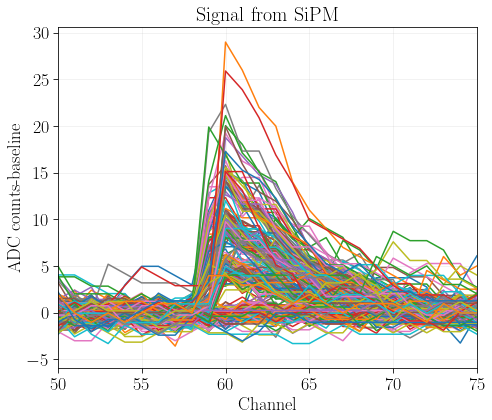

In [9]:
plt.figure(figsize=(7,6))
for i in range(0,9000):
    wf = []
    
    tree.GetEntry(i)
    if(tree.Channel!=0):
        continue
    for sample in tree.Waveform:
        wf.append(sample)
    bl = np.average(wf[0:40]) #baseline
#     peak = np.max(np.array(wf[45:60])-bl)
#     if(peak)>5:
#         continue
    plt.plot(np.array(wf-bl)) #subtract baseline off waveform
plt.xlabel("Channel")
plt.ylabel("ADC counts-baseline")
# plt.legend()
plt.title("Signal from SiPM")
# plt.axvline(45, c = "k", ls="--")
# plt.axvline(60, c = "k", ls="--", label="Window:[56,70]")

plt.xlim(50,75)
plt.grid(alpha=0.2)
# plt.legend()
plt.tight_layout()
# plt.savefig("./Dumpster/wforms_SiPM.pdf")

# Calculate integral with optimal window

In [10]:
integral = []
integral_pe =[]
peak = []
nEntries = tree.GetEntries()
# nEntries = 100000 # Use only first 100000 entries, since it will take a long time to run if we use all entries
for i in range(0,nEntries):
    wf = []
    
    tree.GetEntry(i)
    if(tree.Channel!=0):
        continue
    for sample in tree.Waveform:
        wf.append(sample)
    bl = np.average(wf[0:40])
    integral.append(np.sum(np.array(wf[56:66])-bl))
#     peak.append(np.max(np.array(wf[45:60])-bl))
#     integral_pe.append((np.sum(np.array(wf[45:60])-bl))/19.88)

In [11]:
len(integral)

51482

# Plot spectrum

Text(0.5, 1.0, 'LED pulser @3, amplified, 55 V')

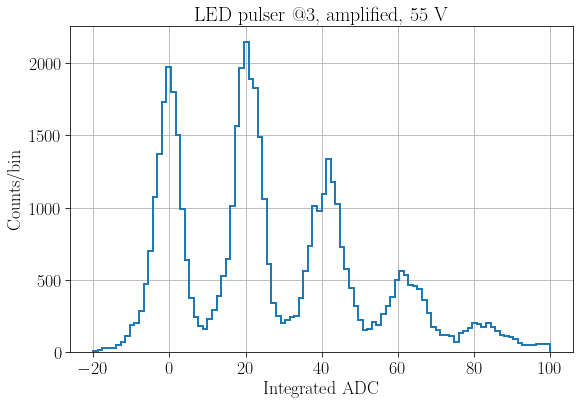

In [12]:
plt.figure(figsize=(9,6))
# 
# sns.kdeplot(integral, );
# sns.distplot(integral, );
plt.hist(np.array(integral), bins=100, range=(-20,100),histtype="step", lw=2, label="[56,66]");

plt.grid()
# plt.yscale("log")
# plt.ylim(1E-4,)
plt.xlabel("Integrated ADC")
plt.ylabel("Counts/bin")
plt.title("LED pulser @3, amplified, 55 V")
# plt.title("Spectrum")
# plt.savefig("./Dumpster/LED_at3_55V.pdf")
# plt.savefig("delete.pdf")

# Perform fit 

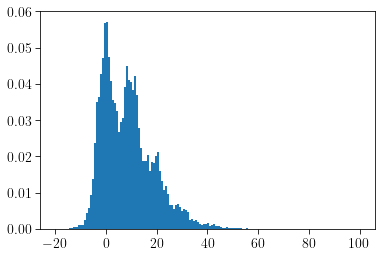

In [166]:
from lmfit.models import GaussianModel, ConstantModel
import scipy.signal
# x, y = np.loadtxt('Peaks.txt', unpack=True)
bin_heights, bin_borders, _ = plt.hist(np.array(integral), bins=150,range=(-20,100), density=True, );
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2

peaks_in_interval = scipy.signal.find_peaks_cwt(bin_heights, widths=5)
number_of_peaks = len(peaks_in_interval)
amplitude = bin_heights[peaks_in_interval]
width = np.zeros(number_of_peaks) + 1
center = bin_centers[peaks_in_interval]

def make_model(num):
    pref = "f{0}_".format(num)
    model = GaussianModel(prefix = pref)
    model.set_param_hint(pref+'amplitude', value=amplitude[num], min=0, max=10*amplitude[num])
    model.set_param_hint(pref+'center', value=center[num], min=center[num]-.5, max=center[num]+.5)
    model.set_param_hint(pref+'sigma', value=width[num], min=0., max=20)
    return model

mod = None
for i in range(len(peaks_in_interval)):
    this_mod = make_model(i)
    if mod is None:
        mod = this_mod
    else:
        mod = mod + this_mod

# offset = ConstantModel()
# offset.set_param_hint('c', value=np.average(bin_heights[-75:]))
mod = mod #+ offset

out=mod.fit(bin_heights, x=bin_centers)
# plt.interactive(True)
# print(out.fit_report())


Text(0.5, 0, 'Integrated ADC [p.e]')

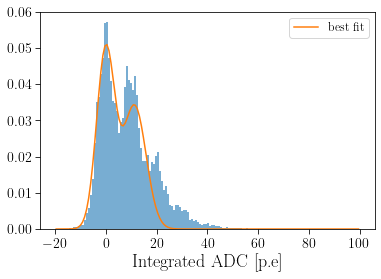

In [167]:
plt.hist(np.array(integral), bins=150,range=(-20,100), density=True, alpha=0.6);
# plt.scatter(bin_centers[peaks_in_interval],bin_heights[peaks_in_interval], c = "red", alpha = 0.3);

plt.plot(bin_centers, out.best_fit, label='best fit')
# plt.plot(bin_centers, out.init_fit, 'r--', label='fit with initial values')
plt.legend()
plt.xlabel("Integrated ADC [p.e]")

In [168]:
out.values

{'f0_amplitude': 0.4442338925763259,
 'f0_center': -0.0841252862844648,
 'f0_sigma': 3.5796560977268244,
 'f1_amplitude': 0.3842821540756627,
 'f1_center': 11.299999999988728,
 'f1_sigma': 4.509786807441011,
 'f0_fwhm': 8.429445772049082,
 'f0_height': 0.04950858015519818,
 'f1_fwhm': 10.619736169898243,
 'f1_height': 0.03399415824777977}

In [169]:
voltages = np.arange(53,60)

In [171]:
values = np.array([0,11.30,16.7,20.70,26.30,31.26,36.18])

In [186]:
data = pd.DataFrame(data = {"voltages":voltages, "gain":values})

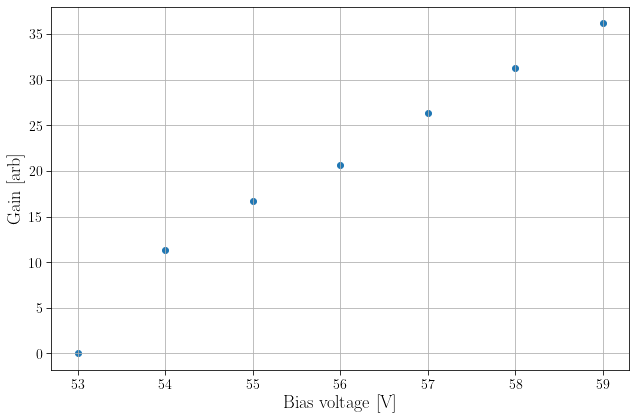

In [172]:
plt.figure(figsize=(9,6))
plt.scatter(voltages, values)
plt.xlabel("Bias voltage [V]")
plt.ylabel("Gain [arb]")
plt.grid()
plt.tight_layout()

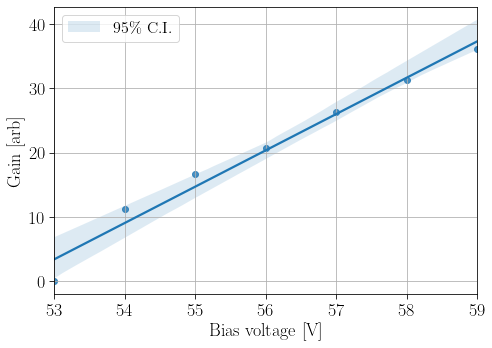

In [207]:
plt.figure(figsize=(7,5))
# plt.scatter(voltages, values)
ax = sns.regplot(data = data, x = "voltages", y = "gain")
plt.xlabel("Bias voltage [V]")
plt.ylabel("Gain [arb]")
ax.collections[1].set_label('$95\%$ C.I.')
plt.grid()
plt.legend(fontsize = 16, loc = "upper left")
plt.tight_layout()
plt.savefig("./Dumpster/linearFit_gainVCurve.pdf")